In [1]:
from experiment import db_utils as db
import pandas as pd
import json
from typing import Callable, Dict, Sequence, Optional, Tuple
from pprint import pprint
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# tools for plotting
def multi_line_plot(x_labels: Sequence[str], 
                    data: Sequence[Sequence],
                    line_labels: Sequence[str],
                    x_label: Optional[str]='',
                    y_label: Optional[str]='', 
                    title: Optional[str]='',
                    figsize: Tuple[int, int]=(5, 4),
                    legend: bool=True):
    
    xs = np.arange(len(x_labels))  # the label locations
    assert len(data) == len(line_labels)
    

    fig, ax = plt.subplots(figsize=figsize)

    
    lines = []
    for i, (ys, label) in enumerate(zip(data, line_labels)):
        line = ax.plot(xs, ys, label=label)
        lines.append(line)
    

    # Add some text for labels, title and custom x-axis tick labels, etc.
    if x_label:
        ax.set_xlabel(x_label)
    if y_label:
        ax.set_ylabel(y_label)
    if title:
        ax.set_title(title)
    ax.set_xticks(xs)
    ax.set_xticklabels(x_labels)
    
    ax.grid()
    if legend:
        ax.legend(prop={"size":13})

    fig.tight_layout()

    plt.show()
    
def multi_bar_plot(x_labels: Sequence[str], 
                   data: Sequence[Sequence],
                   category_labels: Sequence[str],
                   bar_y_label: str, 
                   title: str, 
                   category_styles: Dict={},
                   line_y_label: str=None,
                   width: int=0.7, 
                   bar_label_fmt: str='{:.1%}',
                   x_label_rotation: int=0):
    
    xs = np.arange(len(x_labels))  # the label locations
    assert len(data) == len(category_labels)

    bar_labels = [k for k in category_labels if category_styles.get(k, "bar") == "bar"]
    line_labels = [k for k in category_labels if k in category_styles and category_styles[k] == "line"]
    
    bar_data = [data for data, label in zip(data, category_labels) if label in bar_labels]
    line_data = [data for data, label in zip(data, category_labels) if label in line_labels]

    bar_width = width / len(bar_labels)

    fig, ax = plt.subplots(figsize=(12, 5))
    
    bars = []
    for i, (ys, label) in enumerate(zip(bar_data, bar_labels)):
        bar_positions = xs - width/2 + bar_width * i
        bar = ax.bar(bar_positions, ys, bar_width, label=label, align="edge")
        bars.append(bar)
    
    if not line_y_label:
        lines = []
        for i, (ys, label) in enumerate(zip(line_data, line_labels)):
            color_id = len(bars) + i
            line = ax.plot(xs, ys, color=f"C{color_id}", label=label)

        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_ylabel(bar_y_label)
        ax.set_title(title)
        ax.set_xticks(xs)
        ax.set_xticklabels(x_labels, rotation=x_label_rotation)
        ax.grid()
        ax.legend()
    else:
        ax.set_ylabel(bar_y_label)
        ax.set_title(title)
        ax.set_xticks(xs)
        ax.set_xticklabels(x_labels, rotation=x_label_rotation)
        ax.legend()
        
        ax2 = ax.twinx()
        lines = []
        for i, (ys, label) in enumerate(zip(line_data, line_labels)):
            color_id = len(bars) + i
            line = ax2.plot(xs, ys, color=f"C{color_id}", label=label)
        y_axis_color = f"C{len(bars)}"
        ax2.set_ylabel(line_y_label, color=y_axis_color)
        ax2.tick_params(axis='y', labelcolor=y_axis_color)
        
        ax2.legend()


    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate(bar_label_fmt.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
    
    for bar in bars:
        autolabel(bar)

    fig.tight_layout()

    plt.show()
    

In [3]:
from collections import defaultdict
import re

loc_to_name = ["[CLS]", 
              "QSubj$_1^P$", "QSubj$_2^P$", "AdjSubj$^P$", "NSubj$^P$", "Neg$_1^P$", "Neg$_2^P$", 
               "Adv$^P$", "V$^P$", "QObj$_1^P$", "QObj$_2^P$", "AdjObj$^P$", "NObj$^P$",
              "[SEP]",
              "QSubj$_1^H$", "QSubj$_2^H$", "AdjSubj$^H$", "NSubj$^H$", "Neg$_1^H$", "Neg$_2^H$", 
               "Adv$^H$", "V$^H$", "QObj$_1^H$", "QObj$_2^H$", "AdjObj$^H$", "NObj$^H$",
              "[SEP]"]

# base, IIT, IIT+multitask, augment, multitask
# METHODS_OF_INTEREST = [(0, 0, 0), (1, 0, 0), (1, 0, 1), (0, 1, 0), (0, 0, 1)]
METHODS_OF_INTEREST = [(0, 0, 0), (1, 0, 0), (1, 0, 1), (0, 0, 1)]
LOC_OF_INTEREST = 10

def get_locations(row):
    interx_mappings = json.loads(row['interx_mappings'])
    res = []
    bert_layer = None
    for mapping in interx_mappings:
        vp_loc = mapping['vp']
        if bert_layer is None:
            bert_layer = list(vp_loc.keys())[0]
        loc_str = vp_loc[bert_layer]
        loc_idx = int(re.findall(r', [0-9]+,', loc_str)[0].strip(', '))
        res.append(loc_idx)
    return res

def compute_impactful_success_rates(data):
    # modify data to include impactful interchange success rates as a new column
    for row in data:
        locs = get_locations(row)
        res_2_counts = json.loads(row['res_2_counts'])
        res_3_counts = json.loads(row['res_3_counts'])
        row['loc_idxs'] = locs
        res = [c3 / (c2 + c3) for c2, c3 in zip(res_2_counts, res_3_counts)]
        row['impactful_success_rates'] = res
    return data
        

def get_method_tuple(row):
    return (int(row['mo_cf_weight']), int(row['mo_aug_weight']), int(row['mo_probe_weight']))

def get_layer_num(row):
    mapping = json.loads(row['mapping'])
    high_node_name = list(mapping.keys())[0]
    bert_layer_name = list(mapping[high_node_name].keys())[0]
    return int(bert_layer_name.split('_')[2])

def get_method_str(t):
    if t == (0, 0, 0):
        return 'baseline'
    s = []
    if t[0] == 1:
        s.append('IIT')
    if t[1] == 1:
        s.append('augment')
    if t[2] == 1:
        s.append('multitask')
    return '+'.join(s)

def get_accuracies(data, column_name):
    method_to_accuracies = {}
    for row in data:
        method_tuple = get_method_tuple(row)
        bert_layer_num = get_layer_num(row)
        if column_name == 'impactful_success_rates':
            loc_idx = row['loc_idxs'].index(LOC_OF_INTEREST)
            curr_val = row['impactful_success_rates'][loc_idx]
        else:
            curr_val = row[column_name]
        
        if method_tuple not in method_to_accuracies:
            method_to_accuracies[method_tuple] = {}
        method_to_accuracies[method_tuple][bert_layer_num] = curr_val
    
    return method_to_accuracies

def plot_accuracies(acc_dict, acc_type, legend=True, title=""):
    x_labels = ['0', '2', '4', '6', '8', '10']
    
    line_labels = [get_method_str(t) for t in METHODS_OF_INTEREST]
    data = [list(acc_dict[t].values()) for t in METHODS_OF_INTEREST]
    multi_line_plot(
        x_labels=x_labels,
        data=data,
        line_labels=line_labels,
        x_label='Bert Layer',
        figsize=(4,4),
        legend=legend
    )

def aggregate_per_method(data, column_name):
    method_to_best_val = {}
    method_to_best_layer = {}
    for row in data:
        method_tuple = get_method_tuple(row)
        bert_layer_num = get_layer_num(row)
        if column_name == 'impactful_success_rates':
            loc_idx = row['loc_idxs'].index(LOC_OF_INTEREST)
            curr_val = row['impactful_success_rates'][loc_idx]
        else:
            curr_val = row[column_name]
        
        
        if method_tuple not in method_to_best_val:
            method_to_best_val[method_tuple] = curr_val
            method_to_best_layer[method_tuple] = bert_layer_num
        
        if method_to_best_val[method_tuple] < curr_val:
            method_to_best_val[method_tuple] = curr_val
            method_to_best_layer[method_tuple] = bert_layer_num
    
    return method_to_best_val, method_to_best_layer

def present_max_results(data, column_name):
    method_to_val, method_to_layer = aggregate_per_method(data, column_name)
    for method in METHODS_OF_INTEREST:
        method_str = get_method_str(method)
        print(f'{method_str:16}On layer {method_to_layer[method]} {method_to_val[method]:.2%}')

In [4]:
vp_grid_data = db.select('data/mocf/vp_grid.db', 'results', cond_dict={'status': 1})


SELECT * FROM results WHERE status = 1;


In [5]:
compute_impactful_success_rates(vp_grid_data)

[{'id': 1,
  'data_path': 'data/mqnli/preprocessed/bert-hard_abl.pt',
  'tokenizer_vocab_path': 'data/tokenization/bert-vocab.txt',
  'output_classes': 3,
  'device': 'cuda',
  'train_batch_size': 32,
  'eval_batch_size': 64,
  'optimizer_type': 'adamw',
  'lr': 5e-05,
  'lr_scheduler_type': 'linear',
  'lr_warmup_epoch_ratio': 0.5,
  'weight_norm': 0.0,
  'early_stopping_metric': 'eval_weighted_avg_acc',
  'mo_weight_type': 'fixed',
  'mo_base_weight': 1.0,
  'mo_cf_weight': 0.0,
  'mo_aug_weight': 0.0,
  'mo_probe_weight': 0.0,
  'cf_train_num_random_bases': 50000,
  'cf_train_num_random_ivn_srcs': 20,
  'cf_eval_num_random_bases': 1000,
  'cf_eval_num_random_ivn_srcs': 10,
  'cf_impactful_ratio': 0.5,
  'probe_max_rank': 32,
  'probe_dropout': 0.0001,
  'eval_only': 0,
  'max_epochs': 5,
  'eval_epochs': 1,
  'patient_epochs': 1,
  'run_steps': -1,
  'interx_after_train': 1,
  'interx_num_cf_training_pairs': 0,
  'interx_num_inputs': 1000,
  'interx_batch_size': 128,
  'interx_save_

## Max result per method

In [6]:
present_max_results(vp_grid_data, 'eval_base_acc')

baseline        On layer 4 47.20%
IIT             On layer 8 99.00%
IIT+multitask   On layer 8 100.00%
multitask       On layer 4 61.10%


In [7]:
present_max_results(vp_grid_data, 'eval_cf_acc')

baseline        On layer 4 43.46%
IIT             On layer 4 99.13%
IIT+multitask   On layer 8 99.58%
multitask       On layer 4 60.57%


## Base and counterfactual accuracy per bert layer, for the 'vp' node 

In [18]:
# tools for plotting
def multi_line_plot2(acc_dict1: Sequence[Sequence],
                     acc_dict2: Sequence[Sequence]):
     
    x_labels = ['0', '2', '4', '6', '8', '10']
    line_labels = [get_method_str(t) for t in METHODS_OF_INTEREST]
    xs = np.arange(len(x_labels))  # the label locations

    x_label='Bert Layer'
    title1 = "Behavioral Accuracy"
    title2 = "IIT Accuracy"
    fmts = ['o-', '^-.', 'D--', 'x-', 'X-.', '*--', 'v-']

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 5))
    
    for ax, acc_dict, title in [(ax1, acc_dict1, title1), (ax2, acc_dict2, title2)]:
        data = [list(acc_dict[t].values()) for t in METHODS_OF_INTEREST]
        assert len(data) == len(line_labels)
        lines = []
        for i, (ys, label) in enumerate(zip(data, line_labels)):
            line = ax.plot(xs, ys, fmts[i], label=label, markersize=9)
            lines.append(line)
    
        # Add some text for labels, title and custom x-axis tick labels, etc.

        ax.set_xlabel(x_label, fontsize=12)
        ax.set_title(title, fontsize=15)
        ax.set_xticks(xs)
        ax.set_xticklabels(x_labels, fontsize=13)
        ax.set_ylim([0.3, 1.03])
        ax.grid()
    
    ax2.legend(prop={"size":10}, loc=(0.45, 0.6))

    fig.tight_layout()

    plt.show()

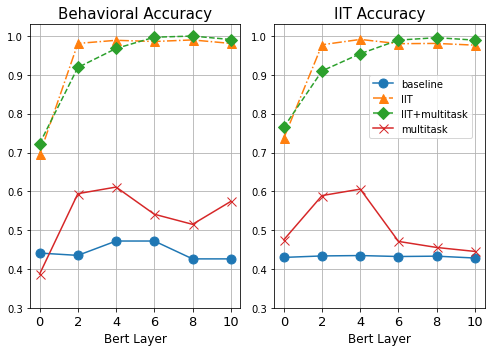

In [19]:
# new paper-style plot

cf_accuracies = get_accuracies(vp_grid_data, 'eval_cf_acc')
base_accuracies = get_accuracies(vp_grid_data, 'eval_base_acc')
interx_success_rates = get_accuracies(vp_grid_data, 'impactful_success_rates')
multi_line_plot2(base_accuracies, cf_accuracies)

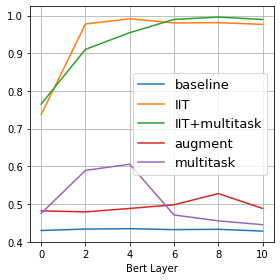

In [24]:
cf_accuracies = get_accuracies(vp_grid_data, 'eval_cf_acc')
plot_accuracies(cf_accuracies, 'Counterfactual Accuracy', title="Factual")

In [16]:
pprint(cf_accuracies)

{(0, 0, 0): {0: 0.4298, 2: 0.4336, 4: 0.4346, 6: 0.4321, 8: 0.433, 10: 0.4282},
 (0, 0, 1): {0: 0.4751, 2: 0.5891, 4: 0.6057, 6: 0.471, 8: 0.4554, 10: 0.4452},
 (0, 1, 0): {0: 0.482, 2: 0.4791, 4: 0.4883, 6: 0.498, 8: 0.5277, 10: 0.4884},
 (0, 1, 1): {0: 0.4917, 2: 0.6347, 4: 0.7711, 6: 0.6223, 8: 0.5952, 10: 0.5121},
 (1, 0, 0): {0: 0.737, 2: 0.9776, 4: 0.9913, 6: 0.9803, 8: 0.981, 10: 0.9765},
 (1, 0, 1): {0: 0.765, 2: 0.9102, 4: 0.9545, 6: 0.9896, 8: 0.9958, 10: 0.9895},
 (1, 1, 0): {0: 0.8159, 2: 0.9987, 4: 0.9993, 6: 0.9995, 8: 0.9984, 10: 0.9954},
 (1, 1, 1): {0: 0.8305, 2: 0.9987, 4: 0.9977, 6: 0.9986, 8: 0.9999, 10: 0.9887}}


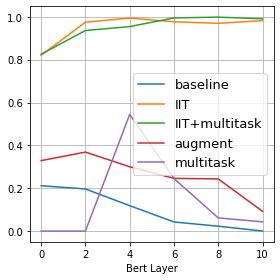

In [25]:
interx_success_rates = get_accuracies(vp_grid_data, 'impactful_success_rates')
plot_accuracies(interx_success_rates, 'Interchange impactful success rate', title="Counterfactual")

In [18]:
pprint(interx_success_rates)

{(0, 0, 0): {0: 0.21172485434262228,
             2: 0.19657724091472414,
             4: 0.11872206153037076,
             6: 0.04253464613706528,
             8: 0.022846476993464697,
             10: 0.0002610181678494565},
 (0, 0, 1): {0: 0.0,
             2: 0.0,
             4: 0.5446142623585458,
             6: 0.24525821092336472,
             8: 0.0615751109192323,
             10: 0.04331775531645111},
 (0, 1, 0): {0: 0.3288080893121805,
             2: 0.3686881177265034,
             4: 0.30018153595201136,
             6: 0.24606102063546353,
             8: 0.24345111245582188,
             10: 0.09222377156287546},
 (0, 1, 1): {0: 0.1745148078963754,
             2: 0.3497259421014321,
             4: 0.6358581739412595,
             6: 0.24715199031808255,
             8: 0.19811448165785298,
             10: 0.031887184614170325},
 (1, 0, 0): {0: 0.8205303783201934,
             2: 0.9746468296293072,
             4: 0.9942682454037481,
             6: 0.9766673924087

## Counterfactual success rate